In [1]:
!pip install mlflow

     |████████████████████████████████| 17.9 MB 1.8 MB/s eta 0:00:01
     |████████████████████████████████| 79 kB 7.7 MB/s eta 0:00:011
     |████████████████████████████████| 209 kB 3.0 MB/s eta 0:00:01
     |████████████████████████████████| 95 kB 1.7 MB/s eta 0:00:01
     |████████████████████████████████| 81 kB 1.8 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 2.4 MB/s eta 0:00:01
     |████████████████████████████████| 8.2 MB 4.1 MB/s eta 0:00:01
     |████████████████████████████████| 181 kB 3.7 MB/s eta 0:00:01
     |████████████████████████████████| 146 kB 4.3 MB/s eta 0:00:01
     |████████████████████████████████| 54 kB 2.8 MB/s eta 0:00:01
     |████████████████████████████████| 63 kB 3.3 MB/s eta 0:00:01
     |████████████████████████████████| 78 kB 2.7 MB/s eta 0:00:01
  Created wheel for databricks-cli: filename=databricks_cli-0.17.0-py3-none-any.whl size=141954 sha256=ccf80f1228be421bf95ef79348ba5cd11200ca42a1bc8b8e0311f4d1b1122d43
  Stored in directory

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.datasets import fashion_mnist
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import roc_auc_score
import mlflow
import mlflow.tensorflow

print(f"Tensorflow : {tf.__version__}")
print(f"scikit-learn : {sklearn.__version__}")
print(f"Numpy : {np.__version__}")
print(f"MLFlow : {mlflow.__version__}")
print(f"Matplotlib : {matplotlib.__version__}")

Tensorflow : 2.7.0
scikit-learn : 1.0.2
Numpy : 1.21.5
MLFlow : 1.27.0
Matplotlib : 3.5.1


In [2]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

Class:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


(<matplotlib.image.AxesImage at 0x280949c70>, None)

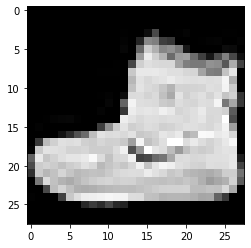

In [3]:
plt.imshow(x_train[0], cmap = 'gray'), print("Class: ", y_train[0])

In [4]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

In [5]:
print("Shapes")
print(f"x_train : {x_train.shape}")
print(f"y_train : {y_train.shape}")
print(f"x_test : {x_test.shape}")
print(f"y_test : {y_test.shape}")

Shapes
x_train : (60000, 28, 28, 1)
y_train : (60000, 10)
x_test : (10000, 28, 28, 1)
y_test : (10000, 10)


In [6]:
# 모델 정의
model = Sequential([
    tf.keras.layers.Reshape((28, 28, 1), input_shape=(28, 28)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax'),
])
model.summary()

Metal device set to: Apple M1 Pro
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)    

2022-07-11 23:42:08.845085: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-11 23:42:08.845218: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
# 컴파일
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['acc'])

# 체크포인트
checkpoint_path = 'my_checkpoint.ckpt'
checkpoint = ModelCheckpoint(filepath = checkpoint_path,
                             save_weights_only = True,
                             save_best_only = True,
                             monitor='val_loss',
                             verbose=1)

In [8]:
# 학습 with MLFlow
mlflow.set_experiment("TF_Keras_fashionMnist")

with mlflow.start_run():

    mlflow.tensorflow.autolog()

    model.fit(x_train, y_train,
              validation_data = (x_test, y_test),
              epochs = 20,
              callbacks = [checkpoint],
              )

    model.load_weights(checkpoint_path)

    preds = model.predict(x_test)
    preds = np.round(preds)

    eval_acc = model.evaluate(x_test, y_test)[1]
    auc_score = roc_auc_score(y_test, preds, multi_class='raise')

    print("eval_acc: ", eval_acc)
    print("auc_score: ", auc_score)

    mlflow.tensorflow.mlflow.log_metric('eval_acc', eval_acc)
    mlflow.tensorflow.mlflow.log_metric('auc_score', auc_score)

mlflow.end_run()

2022/07/11 23:42:08 INFO mlflow.tracking.fluent: Experiment with name 'TF_Keras_fashionMnist' does not exist. Creating a new experiment.
2022-07-11 23:42:09.145428: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/20
   1/1875 [..............................] - ETA: 11:39 - loss: 16.2703 - acc: 0.0625

2022-07-11 23:42:09.372273: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - ETA: 0s - loss: 0.5299 - acc: 0.8242

2022-07-11 23:42:28.146153: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 0.37353, saving model to my_checkpoint.ckpt
1875/1875 [==============================] - 21s 11ms/step - loss: 0.5299 - acc: 0.8242 - val_loss: 0.3735 - val_acc: 0.8696
Epoch 2/20
1875/1875 [==============================] - ETA: 0s - loss: 0.3339 - acc: 0.8786
Epoch 00002: val_loss improved from 0.37353 to 0.35393, saving model to my_checkpoint.ckpt
1875/1875 [==============================] - 20s 11ms/step - loss: 0.3339 - acc: 0.8786 - val_loss: 0.3539 - val_acc: 0.8750
Epoch 3/20
1871/1875 [============================>.] - ETA: 0s - loss: 0.3000 - acc: 0.8893
Epoch 00003: val_loss improved from 0.35393 to 0.32405, saving model to my_checkpoint.ckpt
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3001 - acc: 0.8893 - val_loss: 0.3240 - val_acc: 0.8810
Epoch 4/20
1872/1875 [============================>.] - ETA: 0s - loss: 0.2699 - acc: 0.9001
Epoch 00004: val_loss improved from 0.32405 to 0.31853, saving model to my_c

2022-07-11 23:49:09.750668: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /var/folders/9c/dyfvcxrx45d7q0h1vnt_h6p40000gn/T/tmphhmnriic/model/data/model/assets


2022/07/11 23:49:12 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/yhkoo/miniforge3/envs/deepLearning/lib/python3.8/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils."
2022-07-11 23:49:12.873920: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 2s 7ms/step - loss: 0.2984 - acc: 0.8955
eval_acc:  0.8955000638961792
auc_score:  0.9377500000000001


In [9]:
!mlflow ui -p 9999

[2022-07-11 23:49:16 +0900] [1911] [INFO] Starting gunicorn 20.1.0
[2022-07-11 23:49:16 +0900] [1911] [INFO] Listening at: http://127.0.0.1:9999 (1911)
[2022-07-11 23:49:16 +0900] [1911] [INFO] Using worker: sync
[2022-07-11 23:49:16 +0900] [1913] [INFO] Booting worker with pid: 1913
^C
[2022-07-11 23:52:18 +0900] [1911] [INFO] Handling signal: int
[2022-07-11 23:52:18 +0900] [1913] [INFO] Worker exiting (pid: 1913)


In [10]:
#MLFlow 모델 적재
loaded_model = mlflow.keras.load_model("runs:/a1ea43b0fc37472394ebd100f57cd58a/artifacts/model")

In [11]:
eval_loss, eval_acc = loaded_model.evaluate(x_test, y_test)

preds = loaded_model.predict(x_test)
preds = np.round(preds)

eval_auc = roc_auc_score(y_test, preds)

print("Eval Loss: ", eval_loss)
print("Eval Acc: ", eval_acc)
print("Eval Auc: ", eval_auc)

 15/313 [>.............................] - ETA: 2s - loss: 0.3218 - acc: 0.9042

2022-07-11 23:52:19.689002: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 3s 8ms/step - loss: 0.4096 - acc: 0.8966


2022-07-11 23:52:22.240990: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Eval Loss:  0.4095974266529083
Eval Acc:  0.896600067615509
Eval Auc:  0.9409388888888888
